# Presentation preparation
#  To find out how four of the many geocoders available in [Geopy](https://geopy.readthedocs.io/en/stable/) are differing in their results for the same query.
---
---

In [2]:
# %load nb_cell0.py
import os
import sys

print('Python: {}\n'.format(sys.version))
print('Currrent dir:', os.path.abspath(os.path.curdir))

def add_to_sys_path(this_path, up=False):
    """
    Prepend this_path to sys.path.
    If up=True, path refers to parent folder (1 level up).
    """
    for p in sys.path:
        p = os.path.abspath(p)
    if up:
        newp = os.path.abspath(os.path.join(this_path, '..'))
    else:
        newp = os.path.abspath(this_path)
        
    if this_path not in (p, p + os.sep):
        print('Path added to sys.path: {}'.format(newp))
        sys.path.insert(0, newp)
        
# if notebook inside another folder, eg ./notebooks:
up =  os.path.abspath(os.path.curdir).endswith('notebooks')
add_to_sys_path(os.path.curdir, up)

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)

from pprint import pprint as pp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import HTML, Markdown, IFrame

%load_ext autoreload
%autoreload 2


Python: 3.6.7 (default, Feb 28 2019, 07:28:18) [MSC v.1900 64 bit (AMD64)]

Currrent dir: C:\Users\catch\Documents\GitHub\Geocoders_presentation\notebooks
Path added to sys.path: C:\Users\catch\Documents\GitHub\Geocoders_presentation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import geopy
import geopandas as gpd
import cartopy
import folium

import pycrs
import pyproj

import mpl_toolkits.basemap as mplmap
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from IPython.display import HTML, IFrame

In [4]:
# project imports
from GeocodersComparison import (comparison as GeoComp4,
                                 inspect_geocoders,
                                 gc4utils,
                                 gc4settings)


Places queried, var query_lst:
['New York City, NY, USA', "Cleopatra's needle, Central Park, New York, NY, USA", 'Bronx county, NY, USA', 'Kings county, NY, USA', 'New York county, NY, USA', 'Queens county, NY, USA', 'Richmond county, NY, USA', 'Boston, MA, USA']

Fetching API keys from environment file if found.
Module import operations: COMPLETE.


In [5]:
# Directories:
dir_geo = GeoComp4.DIR_GEO
dir_html = GeoComp4.DIR_HTML
dir_img = GeoComp4.DIR_IMG
dir_shp = GeoComp4.DIR_SHP

dir_raw = os.path.join(dir_geo, 'rawjson')

# Query list:
# Each query list string is passed to the geocoding function.
query_lst = GeoComp4.query_lst
print("List of query strings that will be passed to each geocoder:")
for i, q in enumerate(query_lst):
    print('{}. {!r}'.format(i, q))

# Geoloders in the comparison:
colors_dict = GeoComp4.colors_dict

geocs = GeoComp4.geocs
print("\nGeocoders compared:\n", geocs)

List of query strings that will be passed to each geocoder:
0. 'New York City, NY, USA'
1. "Cleopatra's needle, Central Park, New York, NY, USA"
2. 'Bronx county, NY, USA'
3. 'Kings county, NY, USA'
4. 'New York county, NY, USA'
5. 'Queens county, NY, USA'
6. 'Richmond county, NY, USA'
7. 'Boston, MA, USA'

Geocoders compared:
 ['Nominatim', 'GoogleV3', 'ArcGis', 'AzureMaps']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


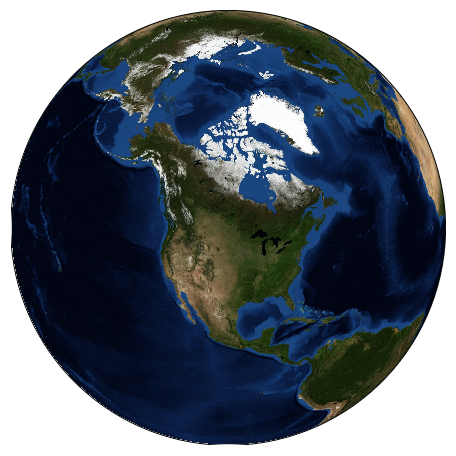

In [6]:
plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
m.bluemarble(scale=0.5);

In [7]:
def projs():
    allprojs = list(mplmap.supported_projections.strip().split('\n'))
    supported_projs = {}

    for i, s in enumerate(allprojs):
        parts = s.strip().partition(' ')
        supported_projs[parts[0]] = parts[-1].strip()
    return supported_projs   


def draw_map(m, scale=0.2, 
             relief=False, 
             lc='w'):
    """
    From jvdp: https://jakevdp.github.io/PythonDataScienceHandbook/
    04.13-geographic-data-with-basemap.html
    with my amendments.
    """ 
    from itertools import chain
    
    # draw a shaded-relief image
    if relief:
        m.shadedrelief(scale=scale)

    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.5, color=lc)


def get_globe(lat0=25, lon0=-40, proj='ortho',
              BW=False, base=False,
             other={}):
    if other:
        m = Basemap(lat_0=lat0, lon_0=lon0,
                projection=proj, **other)
    else:
        m = Basemap(lat_0=lat0, lon_0=lon0,
                projection=proj)
    if base:
        return m
    if BW:
        m.drawmapboundary()
        # to get b&w&g globe:
        m.drawcoastlines()
        m.fillcontinents(color='#5e5c5e',zorder=0, alpha=0.3)
    else:
        m.drawmapboundary(fill_color='lightblue', linewidth=0.4)
        m.fillcontinents(color='#b29b5c',zorder=1,  alpha=0.8)
        m.drawcoastlines(linewidth=0.5, color='white')  
    return m

# Mean Earth Radius: 6371.0088 km  
### as per WGS84, the World Geodetic System revision of 1984 (current)

In [8]:
all_projs = projs()
len(all_projs)
proj_keys = list(all_projs.keys())
all_projs

34

{'cyl': 'Cylindrical Equidistant',
 'merc': 'Mercator',
 'tmerc': 'Transverse Mercator',
 'omerc': 'Oblique Mercator',
 'mill': 'Miller Cylindrical',
 'gall': 'Gall Stereographic Cylindrical',
 'cea': 'Cylindrical Equal Area',
 'lcc': 'Lambert Conformal',
 'laea': 'Lambert Azimuthal Equal Area',
 'nplaea': 'North-Polar Lambert Azimuthal',
 'splaea': 'South-Polar Lambert Azimuthal',
 'eqdc': 'Equidistant Conic',
 'aeqd': 'Azimuthal Equidistant',
 'npaeqd': 'North-Polar Azimuthal Equidistant',
 'spaeqd': 'South-Polar Azimuthal Equidistant',
 'aea': 'Albers Equal Area',
 'stere': 'Stereographic',
 'npstere': 'North-Polar Stereographic',
 'spstere': 'South-Polar Stereographic',
 'cass': 'Cassini-Soldner',
 'poly': 'Polyconic',
 'ortho': 'Orthographic',
 'geos': 'Geostationary',
 'nsper': 'Near-Sided Perspective',
 'sinu': 'Sinusoidal',
 'moll': 'Mollweide',
 'hammer': 'Hammer',
 'robin': 'Robinson',
 'kav7': 'Kavrayskiy VII',
 'eck4': 'Eckert IV',
 'vandg': 'van der Grinten',
 'mbtfpq': 'M

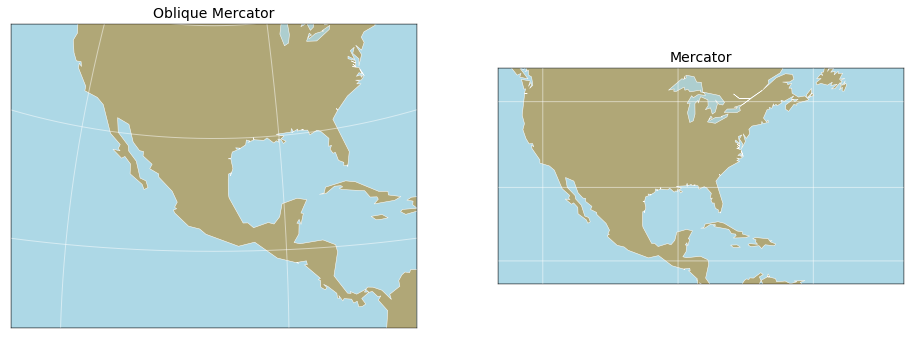

In [13]:
fig = plt.figure(figsize=(16, 10))

latlong_args = dict(width=6000000,height=4500000,
                    lat_1=35.,lon_1=-100.,
                    lat_2=45.,lon_2=-100,
                    o_lon_p=None,o_lat_p=None)

others = dict(llcrnrlon=-130.,llcrnrlat=10.,
              urcrnrlon=-40.,urcrnrlat=50.)

ax = fig.add_subplot(121)
p = 'omerc'
ax.set_title(all_projs[p], fontsize=14);

try:
    m = get_globe(BW=False, proj=p);
except ValueError:
    m = get_globe(BW=False, proj=p, other=latlong_args);
    
draw_map(m);  # with meridians and parallels


ax = fig.add_subplot(122)
p = 'merc'
ax.set_title(all_projs[p], fontsize=14);

m = get_globe(BW=False, proj=p, other=others);
draw_map(m);

fname = os.path.join(dir_img, 'projs_mercator.png')
fig.savefig(fname, transparent=True, pad_inches=0.05);

Text(0.5, 1.0, 'Cylindrical Equidistant')

Text(0.5, 1.0, 'Miller Cylindrical')

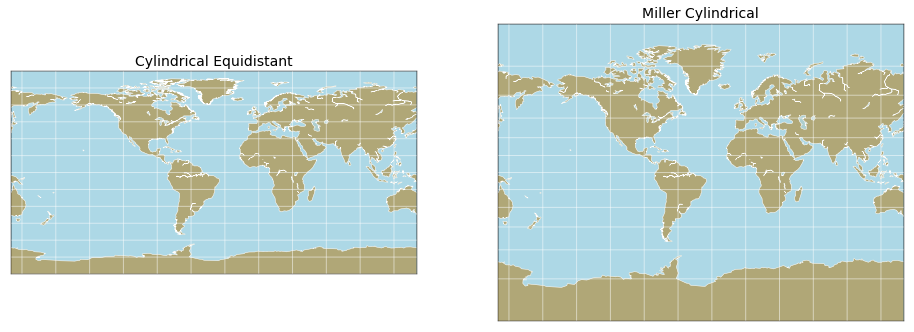

In [14]:
fig = plt.figure(figsize=(16, 10));

ax = fig.add_subplot(121);
p = proj_keys[0]
ax.set_title(all_projs[p], fontsize=14);

m = get_globe(BW=False, proj=p);
draw_map(m);  # with meridians and parallels

ax = fig.add_subplot(122);
p = proj_keys[4]
ax.set_title(all_projs[p], fontsize=14);

m = get_globe(BW=False, proj=p);
draw_map(m);

fname = os.path.join(dir_img, 'projs_cylindrical.png')
fig.savefig(fname, transparent=True, pad_inches=0.05)

Text(0.5, 1.0, 'Mollweide')

Text(0.5, 1.0, 'Orthographic')

Text(0.5, 1.0, 'Near-Sided Perspective')

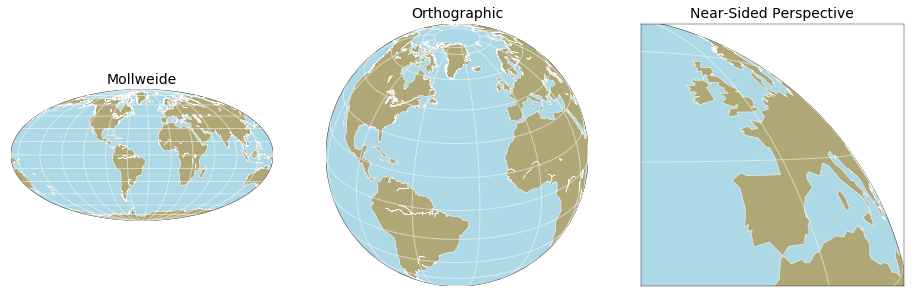

In [15]:
fig = plt.figure(figsize=(16, 10));

ax = fig.add_subplot(131);
p = 'moll'
ax.set_title(all_projs[p], fontsize=14);

m = get_globe(BW=False, proj=p);
draw_map(m);  # with meridians and parallels

ax = fig.add_subplot(132);
p = 'ortho'
ax.set_title(all_projs[p], fontsize=14);

m = get_globe(BW=False, proj=p);
draw_map(m);

ax = fig.add_subplot(133);
p = 'nsper'
ax.set_title(all_projs[p], fontsize=14);

others = dict(satellite_height=3000000.,
              llcrnrx=500000.,llcrnry=500000.,
              urcrnrx=2700000.,urcrnry=2700000.)
m = get_globe(lat0 = 30., lon0 = -27.,
              BW=False, proj=p, other=others);
draw_map(m);

fname = os.path.join(dir_img, 'projs_others.png')
fig.savefig(fname, transparent=True, pad_inches=0.05)

Text(5523512.82551116, 10031712.940276708, 'Primary meridien\n(Greenwich, lon 0)  ')

Text(5275451.533547525, 6712782.907173197, '       ')

Text(5293039.686402075, 7265887.983536333, 'Equator\n(lat 0)')

Text(6370997.0, 4191987.6929325946, 'Mean Earth Radius:\n6,371.0088 km')

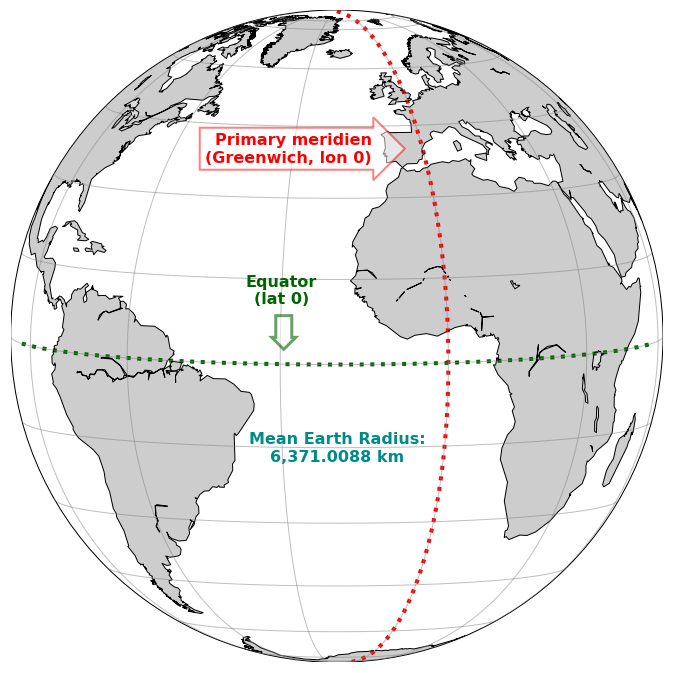

In [21]:
fig = plt.figure(figsize=(12,12));

globe_bw = get_globe(lat0=5, lon0=-20, BW=True);

globe_bw.drawgreatcircle(0, 90, 0.0, -90, 
                  linewidth=4, ls='dotted',
                  color='r', zorder=1);

globe_bw.drawgreatcircle(-95, 0, 55, 0, 
                  linewidth=4, ls='dotted',
                  color='darkgreen', zorder=1);
ax = plt.gca();

x1, y1 = globe_bw(-30, 40)
bbox_props1 = dict(boxstyle='rarrow,pad=0.3', 
                   alpha=0.5, fc='w',
                   ec='r', lw=2);
ax.text(x1, y1,
        'Primary meridien\n(Greenwich, lon 0)  ',
        color='r',
        ha='center', va='center',
        fontsize=16, fontweight='bold',
        bbox=bbox_props1);

x2, y2 = globe_bw(-30, 8)
bbox_props2 = dict(boxstyle='rarrow,pad=0.3', 
                   alpha=0.6, fc='w',
                   ec='darkgreen', lw=3);
ax.annotate("       ",
            xy=(x2, y2),xycoords=ax.transAxes,
            xytext=(x2, y2), textcoords='data',
            rotation=-90,
            rotation_mode='anchor',
            bbox=bbox_props2);

x3, y3 = globe_bw(-30, 13)
ax.text(x3, y3,
        'Equator\n(lat 0)',
        color='darkgreen',
        ha='center', va='center',
        fontsize=16, fontweight='bold');

# Mean Earth Radius: 6371.0088 km  
# as per WGS84, the World Geodetic System revision of 1984
# International Union of Geodesy and Geophysics (IUGG)
bbox_props2 = dict(boxstyle='rarrow,pad=0.3', 
                   alpha=0.6, fc='w',
                   ec='darkgreen', lw=3);

x4, y4 = globe_bw(-20, -15)
ax.text(x4, y4,
        'Mean Earth Radius:\n{:0,.4f} km'.format(6371.0088),
        color='darkcyan',
        ha='center', va='center',
        fontsize=16, fontweight='bold');

draw_map(globe_bw, lc='grey');

fname = os.path.join(dir_img, 'globe_pm_eq.png')
fig.savefig(fname, transparent=True, pad_inches=0.05)

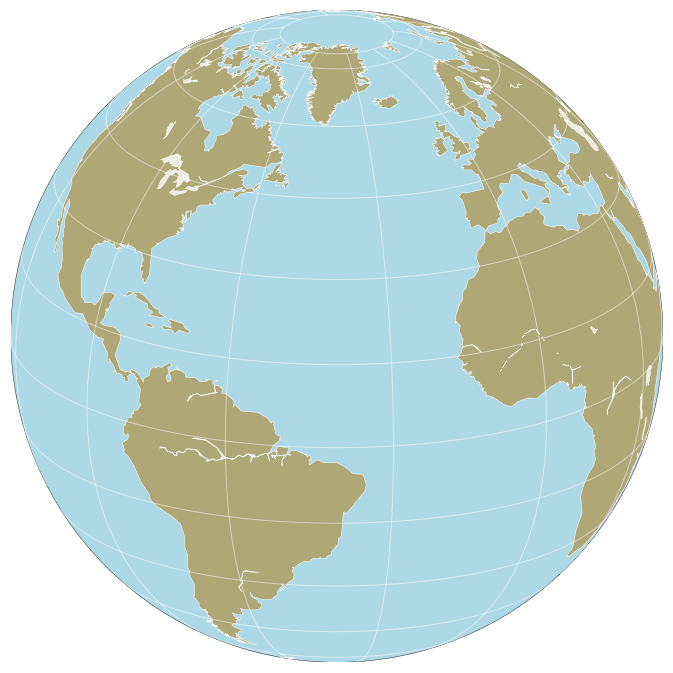

In [77]:
fig = plt.figure(figsize=(12,12));

#plt.title("Orthogonal Projection", fontsize=14);
m = get_globe(lat0=20, lon0=-40,BW=False)
draw_map(m);  # with meridians and parallels

fname = os.path.join(dir_img, 'globe_col_ortho.png')
fig.savefig(fname, transparent=True, pad_inches=0.05)

# Step 1: check shapefile geometry

In [16]:
nyc_shp = GeoComp4.gdf_nyc_counties
boston_shp = GeoComp4.get_gdf_boston()

# Get the crs, do they match?  

## To find the specifics got to https://spatialreference.org and search the database using the epsg number

In [17]:
nyc_shp.crs, boston_shp.crs

({'init': 'epsg:2263'}, {'init': 'epsg:4326'})

# Results for NYC shapefile at  https://spatialreference.org/ref/epsg/2263/:  

## EPSG:2263: NAD83 / New York Long Island (ftUS)

```python
EPSG:2263
NAD83 / New York Long Island (ftUS) (Google it)

WGS84 Bounds: -74.2700, 40.4700, -71.7500, 41.3100
Projected Bounds: 909126.0155, 110626.2880, 1610215.3590, 424498.0529
Scope: Large and medium scale topographic mapping and engineering survey.
Last Revised: Nov. 6, 2001
Area: USA - New York - SPCS - Long island
```

## WKT:
```python
PROJCS["NAD83 / New York Long Island (ftUS)",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4269"]],
    UNIT["US survey foot",0.3048006096012192,
        AUTHORITY["EPSG","9003"]],
    PROJECTION["Lambert_Conformal_Conic_2SP"],
    PARAMETER["standard_parallel_1",41.03333333333333],
    PARAMETER["standard_parallel_2",40.66666666666666],
    PARAMETER["latitude_of_origin",40.16666666666666],
    PARAMETER["central_meridian",-74],
    PARAMETER["false_easting",984250.0000000002],
    PARAMETER["false_northing",0],
    AUTHORITY["EPSG","2263"],
    AXIS["X",EAST],
    AXIS["Y",NORTH]]
```

# Results for City of Boston shapefile at https://spatialreference.org/ref/epsg/4326:  

## EPSG:4326 WGS84

```python
WGS84 Bounds: -180.0000, -90.0000, 180.0000, 90.0000
Projected Bounds: -180.0000, -90.0000, 180.0000, 90.0000
Scope: Horizontal component of 3D system. Used by the GPS satellite navigation system and for NATO military geodetic surveying.
Last Revised: Aug. 27, 2007
Area: World
```


## WKT:
```python
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]

```

# Precision of geo-coordinates: variable (wikipedia):

**Precision**
>The radius of the semi-major axis of the Earth at the equator is 6,378,137.0 meters resulting in a circumference of 40,075,161.2 meters. The equator is divided into 360 degrees of longitude, so each degree at the equator represents 111,319.9 meters or approximately 111.32 km. As one moves away from the equator towards a pole, however, one degree of longitude is multiplied by the cosine of the latitude, decreasing the distance, approaching zero at the pole. The number of decimal places required for a particular precision at the equator is:

**Degree precision versus length**

decimal places	decimal
degrees	DMS	Object that can be unambiguously recognized at this scale	N/S or E/W
at equator	E/W at
23N/S	E/W at
45N/S	E/W at
67N/S
0	1.0	1° 00′ 0″	country or large region	111.32 km	102.47 km	78.71 km	43.496 km
1	0.1	0° 06′ 0″	large city or district	11.132 km	10.247 km	7.871 km	4.3496 km
2	0.01	0° 00′ 36″	town or village	1.1132 km	1.0247 km	787.1 m	434.96 m
3	0.001	0° 00′ 3.6″	neighborhood, street	111.32 m	102.47 m	78.71 m	43.496 m
4	0.0001	0° 00′ 0.36″	individual street, land parcel	11.132 m	10.247 m	7.871 m	4.3496 m
5	0.00001	0° 00′ 0.036″	individual trees, door entrance	1.1132 m	1.0247 m	787.1 mm	434.96 mm
6	0.000001	0° 00′ 0.0036″	individual humans	111.32 mm	102.47 mm	78.71 mm	43.496 mm
7	0.0000001	0° 00′ 0.00036″	practical limit of commercial surveying	11.132 mm	10.247 mm	7.871 mm	4.3496 mm
8	0.00000001	0° 00′ 0.000036″	specialized surveying (e.g. tectonic plate mapping)	1.1132 mm	1.0247 mm	787.1 µm	434.96 µm

> A value in decimal degrees to a precision of 4 decimal places is precise to 11.132 meters at the equator. A value in decimal degrees to 5 decimal places is precise to 1.1132 meter at the equator. Elevation also introduces a small error. At 6,378 m elevation, the radius and surface distance is increased by 0.001 or 0.1%. Because the earth is not flat, the precision of the longitude part of the coordinates increases the further from the equator you get. The precision of the latitude part does not increase so much, more strictly however, a meridian arc length per 1 second depends on the latitude at the point in question. The discrepancy of 1 second meridian arc length between equator and pole is about 0.3 metres because the earth is an oblate spheroid.

In [29]:
ME_rad = 6371 # km + ~ 0.01

---

# 2. Load the data: 
### THIS IS THE DATA LOADING (FETCHING) FUNCTION IF `use_local=True` (`False`):
If `True`, `get_geo_dicts` will check for the json files in "../GeocodersComparison/geodata/";  
If the file does not exist, it will fetch it for each search string and each geocoders.

In [78]:
# Saved geolocation data for each item in query_lst and each geocoder in geocs.
# Returned in a list.
geo_dicts = GeoComp4.get_geo_dicts(geocs, query_lst, use_local=True)


Loading geodata...
Found: : C:\Users\catch\Documents\GitHub\Geocoders_presentation\GeocodersComparison\geodata\geodata_Nom.json, 11 days, 20h 29m 34s old
Found: : C:\Users\catch\Documents\GitHub\Geocoders_presentation\GeocodersComparison\geodata\geodata_Goo.json, 11 days, 20h 29m 34s old
Found: : C:\Users\catch\Documents\GitHub\Geocoders_presentation\GeocodersComparison\geodata\geodata_Arc.json, 11 days, 20h 29m 34s old
Found: : C:\Users\catch\Documents\GitHub\Geocoders_presentation\GeocodersComparison\geodata\geodata_Azu.json, 11 days, 20h 29m 34s old

All geodata variables gathered into list geo_dicts.



# 3. Get helper dicts for accessing the data:

In [79]:
# Places in the query list (they are the keys of the geo dicts), 
# used for accessing data for a particular place:
places, places_to_boros = GeoComp4.get_places(geo_dicts)
print(places)

['New York City', "Cleopatra's needle", 'Bronx county', 'Kings county', 'New York county', 'Queens county', 'Richmond county', 'Boston']


### Output example: data from Nominatim, the search engine of OpenStreetMap:

In [80]:
geo = geo_dicts[0]
p = places[0]
geo[p]

{'loc': [40.7308619, -73.9871558],
 'box': [[40.9161785, -73.7001809], [40.477399, -74.25909]]}

# 4. Get dictionnary of DataFrames holding the location data and the distance differences

In [81]:
df_dict = GeoComp4.get_df_dict(geocs, geo_dicts, places)
print(list(df_dict.keys()))

['New York City', "Cleopatra's needle", 'Bronx county', 'Kings county', 'New York county', 'Queens county', 'Richmond county', 'Boston']


# 5. Load the geopandas dfs with shapefiles for maps:  

Note: The NYC shapefile is that which inculdes the water boundaries; it did not find the equivalent for Boston.

In [82]:
gdf_nyc_counties = GeoComp4.gdf_nyc_counties
gdf_boston = GeoComp4.gdf_boston

In [11]:
gdf_nyc_counties

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,1,Manhattan,203598.842067,9.443174e+08,"(POLYGON ((972081.7882080078 190733.4672241211, 972184.7658081055 190551.1359863281, 972398.541809082 190683.2208251953, 972384.9672241211 190709.016784668, 972407.1726074219 190721.4761962891, 97..."
1,2,Bronx,188054.398137,1.598379e+09,"POLYGON ((1021632.335632324 267934.4393920898, 1022108.577392578 267751.4205932617, 1022178.322021484 267761.5264282227, 1022216.077819824 267733.7739868164, 1022272.629394531 267697.1401977539, 1..."
2,5,Staten Island,210579.552313,2.532696e+09,"POLYGON ((968762.0665893555 175987.7493896484, 968654.2512207031 172187.4044189453, 968642.4882202148 171772.7758178711, 968623.9392089844 171379.014831543, 968576.4147949219 169443.7833862305, 96..."
3,3,Brooklyn,234978.813843,2.684409e+09,"POLYGON ((1001565.427429199 205174.1108398438, 1002424.723632813 204811.3392333984, 1003145.585021973 204689.5776367188, 1003869.71081543 204434.3583984375, 1003889.956787109 204421.4630126953, 10..."
4,4,Queens,429317.571157,3.858021e+09,"POLYGON ((1045438.074584961 235083.2955932617, 1049675.844787598 228569.0469970703, 1051509.902832031 227076.2908325195, 1053260.729187012 224604.1929931641, 1053403.75402832 224455.0557861328, 10..."


In [12]:
gdf_boston

,BoroCode,BoroName,Shape_Area,Shape_Leng,geometry
0,1,Boston,1.346516e+09,816364.595339,"(POLYGON ((-71.19082535714033 42.28331516607344, -71.17871065804185 42.29448202254805, -71.16462312543568 42.30376625100558, -71.16386528078513 42.30321329400012, -71.16176080751673 42.30168331420..."


---
# Reporting: Prepare tables, images maps for use in final report.
---

# Output tables to html

# R.1. Table 1: Bounding box comparison between NYC and its county. Are they the same?  

## Purpose: To find out if my hypothesis that they should bears out.  

In [13]:
# Table 1: Save html tbl for ('New York City', 'New York county') comp:
Table1 = os.path.join(dir_html, 'comp_NYC_NYCcnty_tbl.html')

df_T_1 = GeoComp4.compare_two_geoboxes(places[0], places[4], geocs, geo_dicts)
df_title = "Table 1: Same box for {} and that of its county?".format(places[0])

GeoComp4.save_df_table_to_html(df_T_1, df_title, Table1)

# display:
HTML(filename = Table1)

,Identical
,bounding boxes?
New York City & New York county:,
Nominatim,False
GoogleV3,True
ArcGis,True
AzureMaps,False


### Table 1: Alternate output as picture: may not be needed depending on the report type.

In [14]:
GeoComp4.df_to_pic(df_T_1, save_tbl_name='comp_NYC_NYCcnty_tbl');

#### Example of picture output (embedded in markdown):

![Output of GeoComp4.df_to_pic(df_T_1, save_tbl_name='comp_NYC_NYCcnty_tbl')](../GeocodersComparison/images/comp_NYC_NYCcnty_tbl.svg)

# R.2. Table 2:
## Comparison of the center of the bounding box of a place with its location coordinates: Are they the same?  

## Purpose:  
* To find out the relationship between the two, for instance, the location of a county (usually) returns the coordinates of the administrative county seat, so there should not be identical to the center of the county bounding box.
* To discover the consistency of each geocoders: ArcGis and GoogleV3 are the most consistent (with the exception of "Cleopatra's needle", which is a monument, for the later).
However, they are "anticorrelated": with ArcGis, the answer is always True and its is ~always False with GoogleV3.
Surely, both cannot be right (more on this later)!

In [15]:
# Table 2: Save html tbl for the center of box comparison:
Table2 = os.path.join(dir_html, 'comp_Loc_Center_tbl.html')

# Retrieve the comaprison calculations:
df_T_2 = GeoComp4.compare_location_with_geobox(places, geocs, geo_dicts)
#print('Docstring info:\n',GeoComp4.compare_location_with_geobox.__doc__)

# save output as html:
df_title = "Table 2: Place's coordinates identical to the center of its bounding box?"

GeoComp4.save_df_table_to_html(df_T_2.style, df_title, Table2)

# display:
HTML(filename = Table2)

,Nominatim,GoogleV3,ArcGis,AzureMaps
Location is box center?,,,,
New York City,False,False,True,False
Cleopatra's needle,True,True,True,True
Bronx county,True,False,True,False
Kings county,False,False,True,True
New York county,False,False,True,True
Queens county,False,False,True,False
Richmond county,False,False,True,True
Boston,False,False,True,False


In [16]:
GeoComp4.df_to_pic(df_T_2, save_tbl_name='comp_Loc_Center_tbl')

![Output of GeoComp4.df_to_pic(df_T_2, save_tbl_name='comp_Loc_Center_tbl')](../GeocodersComparison/images/comp_Loc_Center_tbl.svg)

# R.3. Table 3: Pairwise, quantitative comparison of the geocoders' results: Is there a huge difference?  

## First load the prepared dataframes; 1st df: location & corners (lat, lon), 2nd df: pairwise distance difference:

In [17]:
# Output them all:
all_tables_3 = GeoComp4.output_tables_3(places, df_dict)

In [18]:
HTML(all_tables_3[0])

In [19]:
HTML(all_tables_3[1])

In [20]:
HTML(all_tables_3[2])

In [21]:
HTML(all_tables_3[3])

In [22]:
HTML(all_tables_3[4])

In [23]:
HTML(all_tables_3[5])

In [24]:
HTML(all_tables_3[6])

In [25]:
HTML(all_tables_3[7])

# R.4: Heatmaps of quantitative differences

## Provides a visual summary of the geodesic distance differences

Notes:
* The heatmap coloring is calculated given an acceptable difference of 5 km (`my_max_acceptable_difference = 5`)
* By default, the plot is saved and not shown --the next cell is used to display it.
* The first time run of get_geo_dist_heatmap() takes ~ 8 seconds, the next one under 3.

# Heatmap 1: Distance differences in kilometers (default unit)

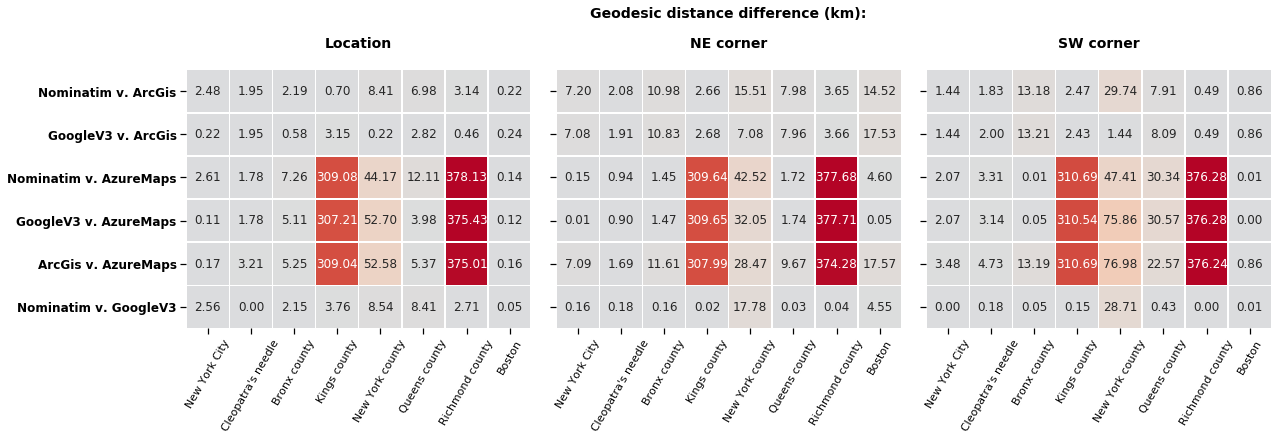

In [26]:
# comment to use existing image
GeoComp4.get_geo_dist_heatmap(places, df_dict)  #, save_fig=False)

### To embed existing image in markdown: 
```
![Output of GeocodersComparison.get_geo_dist_heatmap(places, df_dict)](../GeocodersComparison/images/Heatmap_sns_geodist_difference_km.svg)
```

![Output of GeocodersComparison.get_geo_dist_heatmap(places, df_dict)](../GeocodersComparison/images/Heatmap_sns_geodist_difference_km.svg)

# Heatmap 2: Distance differences in miles

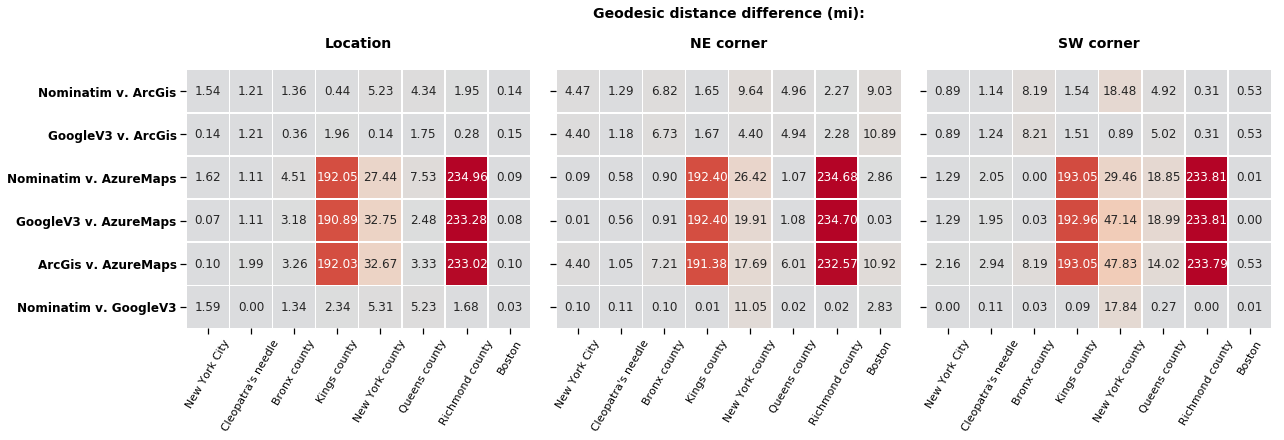

In [27]:
GeoComp4.get_geo_dist_heatmap(places, df_dict, unit='mi')

---
---
# Maps!

---

## New York City

In [83]:
p = places[0]
df1 = df_dict[p][0]

print('Result map for this query: "{}"'.format(query_lst[0]))
boro = places_to_boros[p]
m_nyc = GeoComp4.get_boro_maps(boro, df1, gdf_nyc_counties, filter_bounds=False, zoom=9.5, colors_d=colors_dict)
m_nyc

Result map for this query: "New York City, NY, USA"


In [84]:
m_nyc.crs

'EPSG3857'

https://epsg.io/3857

## New York county (Manhattan)

In [85]:
p = places[4]
boro = places_to_boros[p]
df2 = df_dict[p][0]

print('Result map for this query: "{}"'.format(query_lst[4]))
m_nyc_county = GeoComp4.get_boro_maps(boro, df2, gdf_nyc_counties, colors_d=colors_dict)
m_nyc_county

Result map for this query: "New York county, NY, USA"


## Cleopatra's needle in Central Park

In [30]:
p = places[1]
boro = places_to_boros[p]

df3 = df_dict[p][0]

print('Result map (zoom=11) for this query: "{}"'.format(query_lst[1]))
m_cleo = GeoComp4.get_boro_maps(boro, df3, gdf_nyc_counties, zoom=11, colors_d=colors_dict, file_suffix='zoomed_out')
m_cleo

Result map (zoom=11) for this query: "Cleopatra's needle, Central Park, New York, NY, USA"


In [31]:
# Same, zoomed
print('Result map (zoom=18) for this query: "{}"'.format(query_lst[1]))
GeoComp4.get_boro_maps(boro, df3, gdf_nyc_counties, zoom=18, colors_d=colors_dict, file_suffix='zoomed_in')

Result map (zoom=18) for this query: "Cleopatra's needle, Central Park, New York, NY, USA"


## Bronx

In [32]:
p = places[2]
boro = places_to_boros[p]
df4 = df_dict[p][0]

print('Result map for this query: "{}"'.format(query_lst[2]))
m_bronx = GeoComp4.get_boro_maps(boro, df4, gdf_nyc_counties,colors_d=colors_dict)
m_bronx

Result map for this query: "Bronx county, NY, USA"


## Brooklyn

In [33]:
p = places[3]
boro = places_to_boros[p]
df5 = df_dict[p][0]

print('Result map (zoom=11) for this query: "{}"'.format(query_lst[3]))
m_brooklyn = GeoComp4.get_boro_maps(boro, df5, gdf_nyc_counties, colors_d=colors_dict, zoom=11, file_suffix='zoomed_in')
m_brooklyn

Result map (zoom=11) for this query: "Kings county, NY, USA"


In [34]:
print('Result map (zoom=7) for this query: "{}"'.format(query_lst[3]))
GeoComp4.get_boro_maps(boro, df5, gdf_nyc_counties, colors_d=colors_dict, zoom=7, file_suffix='zoomed_out')

Result map (zoom=7) for this query: "Kings county, NY, USA"


## Queens

In [35]:
p = places[5]
boro = places_to_boros[p]

df6 = df_dict[p][0]

print('Result map for this query: "{}"'.format(query_lst[5]))
m_queens = GeoComp4.get_boro_maps(boro, df6, gdf_nyc_counties, colors_d=colors_dict)
m_queens

Result map for this query: "Queens county, NY, USA"


## Richmond county (Staten Island)

In [36]:
p = places[6]
boro = places_to_boros[p]

df7 = df_dict[p][0]
#df7
print('Result map (zoom=11) for this query: "{}"'.format(query_lst[6]))
m_si = GeoComp4.get_boro_maps(boro, df7, gdf_nyc_counties, colors_d=colors_dict, zoom=11, file_suffix='zoomed_in')
m_si

Result map (zoom=11) for this query: "Richmond county, NY, USA"


In [37]:
# Same, zoomed out:
print('Result map (zoom=7) for this query: "{}"'.format(query_lst[6]))
GeoComp4.get_boro_maps(boro, df7, gdf_nyc_counties, colors_d=colors_dict, zoom=7, file_suffix='zoomed_out')

Result map (zoom=7) for this query: "Richmond county, NY, USA"


## Boston
 
### This Folium map [does not display in notebook cell via Chrome,](https://github.com/python-visualization/folium/issues/812#issuecomment-361713656) but is correctly saved. I use `IPython.display.IFrame` to show it.

Note: Simplifying the shapefile geometry fixes the problem but it creates artifacts due to the complicated shape, so I did not use it.

In [89]:
p = places[7]
boro = 'Boston'
df8 = df_dict[p][0]

print('Result map for this query: "{}"'.format(query_lst[7]))
m_boston = GeoComp4.get_boro_maps(boro, df8, gdf_boston, filter_bounds=False, colors_d=colors_dict, zoom=11)

Result map for this query: "Boston, MA, USA"


In [90]:
m_boston.crs

'EPSG3857'

In [91]:
# the relative path is needed for IFrame
dir_rel_boston = os.path.relpath(os.path.join(dir_html, 'Boston.html'))
IFrame(dir_rel_boston, 1260, 600)

---

In [40]:
gc4utils.caveat_codor()

The code and information herein is valid given my understanding and this environment:<br>3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)] | win32<br>As of:  April 2019